In [2]:
import os
import numpy as np
import h5py

import matplotlib.pyplot as plt

In [3]:
nexus_file = "/SNS/VENUS/IPTS-34969/nexus/VENUS_7549.nxs.h5"
assert os.path.exists(nexus_file)

In [14]:
with h5py.File(nexus_file, 'r') as hdf5_data:
    event_time_offset_original = hdf5_data['entry']['bank100_events']['event_time_offset'][:]
    event_id_original = hdf5_data['entry']['bank100_events']['event_id'][:]

offset_value = 1000000 # stupid 1million value offset
event_id_original -= offset_value



In [15]:
print(f"{np.max(event_time_offset_original) = }")
print(f"{np.min(event_time_offset_original) = }")

np.max(event_time_offset_original) = 18064466.0
np.min(event_time_offset_original) = 0.0


In [47]:
# DEBUGGING
# let's work with only the first n events
n_events= len(event_time_offset_original)
print(f"{n_events} events found in the dataset.")    # 1billion 2500millions events
n_events = 300000000
event_time_offset = event_time_offset_original[:n_events]
event_id = event_id_original[:n_events]

1251564777 events found in the dataset.


In [48]:
# plt.figure(0)
# plt.plot(event_time_offset, '*')

Text(0, 0.5, 'counts')

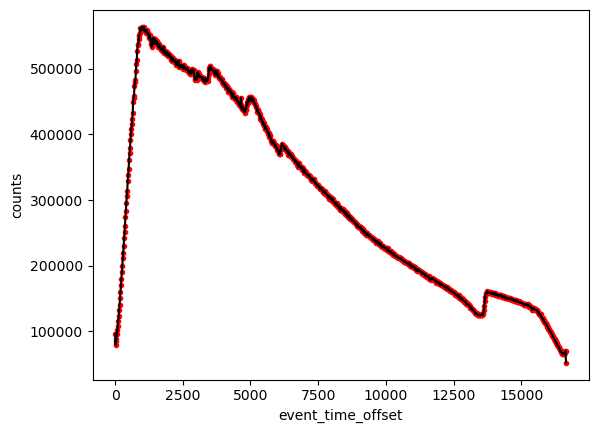

In [ ]:
hist, bin_edges = np.histogram(event_time_offset, bins=1000, range=(0, 16667))

bins_to_plot = bin_edges[:-1]

# zoom
bins_after_zoom = bins_to_plot
hist_after_zoom = hist

plt.figure(2)
plt.plot(bins_after_zoom, hist_after_zoom, 'r.', label='event_time_offset')
plt.plot(bins_after_zoom, hist_after_zoom, 'k-')
plt.xlabel('event_time_offset (us)')
plt.ylabel('counts')
# plt.figure(1)
# plt.plot(event_id)

In [57]:
16667/1000

16.667

In [ ]:
# how many bins if bin size is 0.1111
# 16667 / 0.1111 = 150000

Text(0, 0.5, 'counts')

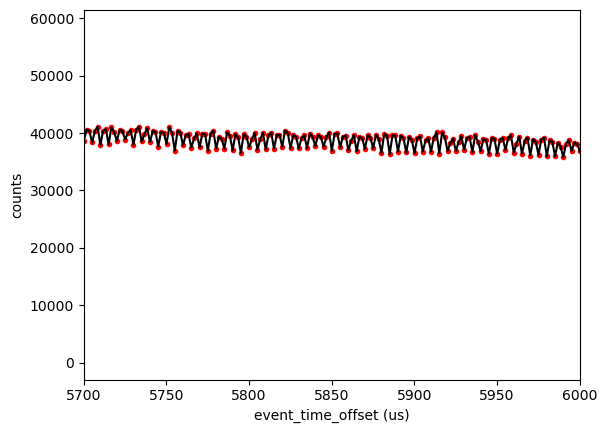

In [53]:
hist, bin_edges = np.histogram(event_time_offset, bins=10000, range=(0, 16667))

bins_to_plot = bin_edges[:-1]

# zoom
bins_after_zoom = bins_to_plot
hist_after_zoom = hist

plt.figure(2)
plt.plot(bins_after_zoom, hist_after_zoom, 'r.', label='event_time_offset')
# xaxis limits 
plt.xlim(5700, 6000)
plt.plot(bins_after_zoom, hist_after_zoom, 'k-')
plt.xlabel('event_time_offset (us)')
plt.ylabel('counts')

Text(0, 0.5, 'counts')

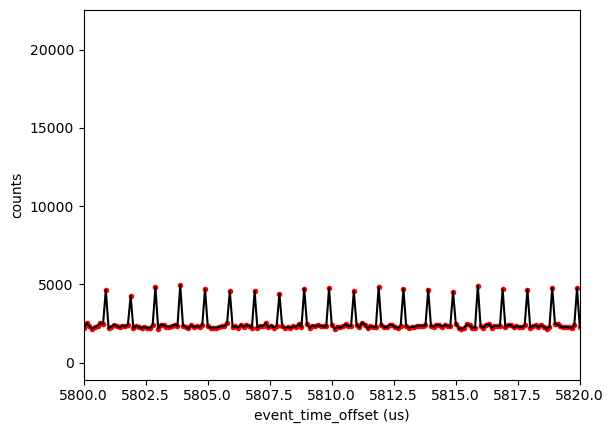

In [56]:
hist, bin_edges = np.histogram(event_time_offset, bins=150000, range=(0, 16667))

bins_to_plot = bin_edges[:-1]

# zoom
bins_after_zoom = bins_to_plot
hist_after_zoom = hist

plt.figure(2)
plt.plot(bins_after_zoom, hist_after_zoom, 'r.', label='event_time_offset')
# xaxis limits 
plt.xlim(5800, 5820)
plt.plot(bins_after_zoom, hist_after_zoom, 'k-')
plt.xlabel('event_time_offset (us)')
plt.ylabel('counts')

In [ ]:
plt.figure(3)
plt.plot(event_id[0:40000])
# max_pixel_id = np.max(event_id)
# min_pixel_id = np.min(event_id)
# print(f"{max_pixel_id = }")
# print(f"{min_pixel_id = }")


In [ ]:
1/60   # 16.67 ms, 16666.67 us, 16666667 ns

0.016666666666666666

In [ ]:
number_of_pixels_per_chip = int(512 * 512 / 4)
print(f"number_of_pixels_per_chip = {number_of_pixels_per_chip}")

In [ ]:
banks = {0: {'from': 0, 'to': number_of_pixels_per_chip - 1},
         1: {'from': number_of_pixels_per_chip, 'to': 2 * number_of_pixels_per_chip - 1},
         2: {'from': 2 * number_of_pixels_per_chip, 'to': 3 * number_of_pixels_per_chip - 1},
         3: {'from': 3 * number_of_pixels_per_chip, 'to': 4 * number_of_pixels_per_chip - 1}}

In [ ]:
list_of_banks_pixelid_belongs_to = np.zeros_like(event_id, dtype=np.uint8)

list_of_banks_pixelid_belongs_to[event_id < banks[0]['to']] = 0
list_of_banks_pixelid_belongs_to[(event_id >= banks[1]['from']) & (event_id < banks[1]['to'])] = 1
list_of_banks_pixelid_belongs_to[(event_id >= banks[2]['from']) & (event_id < banks[2]['to'])] = 2
list_of_banks_pixelid_belongs_to[event_id >= banks[3]['from']] = 3

list_of_banks_pixelid_belongs_to = list_of_banks_pixelid_belongs_to.tolist()


In [ ]:
plt.figure(4)
plt.title("Pixel ID belongs to which bank")
plt.plot(list_of_banks_pixelid_belongs_to, '*r')
plt.yticks([0, 1, 2, 3], ['Bank 0', 'Bank 1', 'Bank 2', 'Bank 3'])
plt.xlabel("Pixel ID")

In [ ]:
# mapping pixels from bank0 (top to bottom) (right to left)
def map_pixel_to_coordinates_bank0(pixel_id):
    """Maps a pixel ID to its (x, y) coordinates in the 2D array.
    bank0 is at the top right corner of the 2D array.
    """
    row = pixel_id % 256
    col = pixel_id // 256
    # to move the col index in the top left corner
    col = 255 - col
    col += 256 # for the big picture
    return row, col  # (y, x) coordinates

# Unit tests
def test_map_pixel_to_coordinates_bank0():
    assert map_pixel_to_coordinates_bank0(0) == (0, 511)
    assert map_pixel_to_coordinates_bank0(255) == (255, 511)
    assert map_pixel_to_coordinates_bank0(256) == (0, 510)
    assert map_pixel_to_coordinates_bank0(65535) == (255, 256)

def map_pixel_to_coordinates_bank1(pixel_id):
    """Maps a pixel ID to its (x, y) coordinates in the 2D array for bank 1.
    bank1 is at the top left corner (from where the numpy 0, 0 is located).
    """
    pixel_id -= 256 * 256
    row, col = map_pixel_to_coordinates_bank0(pixel_id)
    col -= 256
    return row, col

def test_map_pixel_to_coordinates_bank1():
    assert map_pixel_to_coordinates_bank1(65536) == (0, 255)
    assert map_pixel_to_coordinates_bank1(65791) == (255, 255)
    assert map_pixel_to_coordinates_bank1(65792) == (0, 254)
    assert map_pixel_to_coordinates_bank1(131071) == (255, 0)

def map_pixel_to_coordinates_bank2(pixel_id):
    """Maps a pixel ID to its (x, y) coordinates in the 2D array for bank 2.
    bank2 is at the bottom left corner.
    """
    pixel_id -= 2 * 256 * 256
    row = 511 - pixel_id % 256
    col = pixel_id // 256
    return row, col

# Unit test for map_pixel_to_coordinates_bank2
def test_map_pixel_to_coordinates_bank2():
    assert map_pixel_to_coordinates_bank2(256*256*2) == (511, 0)
    assert map_pixel_to_coordinates_bank2(256*256*3-1) == (256, 255)
    assert map_pixel_to_coordinates_bank2(256*256*2+256) == (511, 1)
    assert map_pixel_to_coordinates_bank2(3*256*256-256) == (511, 255)

def map_pixel_to_coordinates_bank3(pixel_id):
    """Maps a pixel ID to its (x, y) coordinates in the 2D array for bank 3.
    bank3 is at the bottom right corner.
    """
    pixel_id -= 3 * 256 * 256
    row = 511 - pixel_id % 256
    col = pixel_id // 256
    col += 256 # for the big picture
    return row, col

# Unit test for map_pixel_to_coordinates_bank3
def test_map_pixel_to_coordinates_bank3():
    assert map_pixel_to_coordinates_bank3(256*256*3) == (511, 256)
    assert map_pixel_to_coordinates_bank3(256*256*3+255) == (256, 256)
    assert map_pixel_to_coordinates_bank3(256*256*4-1) == (256, 511)

# Run the test
test_map_pixel_to_coordinates_bank0()
test_map_pixel_to_coordinates_bank1()
test_map_pixel_to_coordinates_bank2()
test_map_pixel_to_coordinates_bank3()




In [ ]:
full_image = np.zeros((512, 512), dtype=np.int32)
for _index_px, _px_id in enumerate(event_id):
    _bank_id = list_of_banks_pixelid_belongs_to[_index_px]
    if _bank_id == 0:
        row, col = map_pixel_to_coordinates_bank0(_px_id)
    elif _bank_id == 1:
        row, col = map_pixel_to_coordinates_bank1(_px_id)
    elif _bank_id == 2:
        row, col = map_pixel_to_coordinates_bank2(_px_id)
    else:
        row, col = map_pixel_to_coordinates_bank3(_px_id)

    full_image[row, col] += 1



In [ ]:
plt.figure(0, figsize=(10,10))
plt.imshow(full_image, cmap='viridis', interpolation='nearest')